# Overview of Further Probabilistic Models

## Naives Bayes Classification

For a given class $k$, we can use Bayes' theorem 

$$
\begin{align} 
p(C_l~|~x) &= \frac{p(x~|~C_l) ~ p(C_l)}{p(x)}
\end{align} 
$$

with a **naive assumption** that the feature $x = (x_1, \dots, x_n)$ are **conditionally independent**
which allows us to express the contitional propability term $p(x~|~C_l)$ as a product of conditional probabilities of individual features $x_i$.


$$
\begin{align} 
p(C_l~|~x) &= \frac{\prod_{i=1}^n p(x_i~|~C_l) ~ p(C_l)}{p(x)}
\end{align} 
$$

We can now omit $p(x)$, since it does not depend on $l$. Now we can search with a optimization algorithm to find the class which maximises the probability $p(C_l~|~x)$. We call this maximimum a posterior (MAP) decision rule.


$$\hat{y} = \text{argmax}_{l=1,\dots,k} ~\prod_{i=1}^n p(x_i~|~C_l)~p(C_l)  $$


Limits of NBC:
->aspect covariance

So the independece implies zero covariance between two random variables. A non zero covariance leads to Gaussian Mixture Model.


## Gaussian Mixture Model

If we generalize the Naive Bayes approach to a non zero covariance matrix, we arrive at Gaussian Mixture Model (GMM) where we assume multivariate Normal distribution 

$$
P(X=x~|~C=j) = \mathcal{N_p}(x;\mu_j,\Sigma_j)
$$

with mean $\mu \in \mathbb{R}^d $ and covariance matrix $\Sigma \in \mathbb{R}^{d\times d }$.

The marginal propability $P(X)$ is a Gaussian Mixture that is weighted sum of mulitvariate Normal distributions

$$
P(X=x) = \sum_{j=1}^k\pi_j\mathcal{N_p}(x;\mu_j,\Sigma_j)
$$
where $\pi_j:= P(C=j)$ is a mixture coeffiecent for which applies
$$
\sum_{j=1}^J\pi_j=1.
$$
For example a gaussian Mixture would be

$$
P(X=x) = \frac{1}{2}\mathcal{N_2}(\mu_0,\Sigma_0+\frac{1}{2}\mathcal{N_2}(\mu_1,\Sigma_1)
$$
with 
$$
\pi_{0,1}=0.5,\quad \mu_0=[0,0],\quad \mu_1=[1.5,-1.5].\quad \Sigma_{0,1}=
\left[\begin{array}{rr} 
1 & 0.95  \\ 
0.95 & 1  \\ 
\end{array}\right]
$$


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from matplotlib import cm

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.metrics import adjusted_mutual_info_score

plt.style.use('default')
sns.set_style("whitegrid")

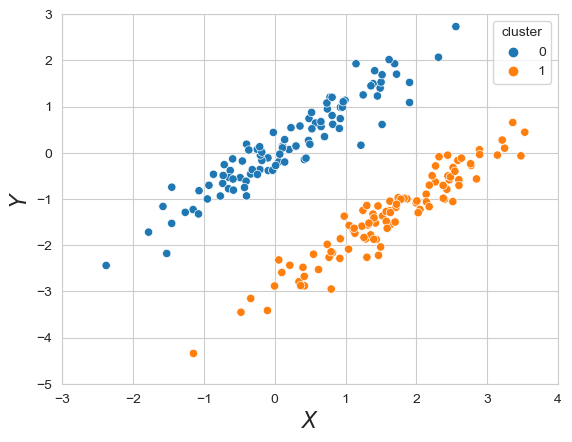

In [43]:
mean_1=[0,0]
cov_1=[[1, 0.95],[0.95, 1]]
x = multivariate_normal.rvs(mean=mean_1, cov=cov_1, size=100)
data_cigars_1 = pd.DataFrame( {'x': x[:,0], 'y': x[:,1], 'cluster': [0]*100 })

mean_2=[1.5,-1.5]
cov_2=[[1, 0.95],[0.95, 1]]
x = multivariate_normal.rvs(mean=mean_2, cov=cov_2, size=100)
data_cigars_2 = pd.DataFrame( {'x': x[:,0], 'y': x[:,1], 'cluster': [1]*100 })

data_cigars = data_cigars_1.append(data_cigars_2)

sns.scatterplot(x='x', y='y', data=data_cigars, hue='cluster')
plt.xlim(-3, 4)
plt.ylim(-5, 3)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16);

In [44]:
def gaussian_mixture_proba(pos_for_pdf, mu, cov, pi):
    s = 0
    k = len(mu)
    for j in range(k):
        s += pi[j] * multivariate_normal.pdf(pos_for_pdf, mu[j], cov[j]) 
    return s

In [49]:
mu = np.array([mean_1, mean_2])
cov = np.array([np.array(cov_1), np.array(cov_2)])
pi = np.array([0.5, 0.5])

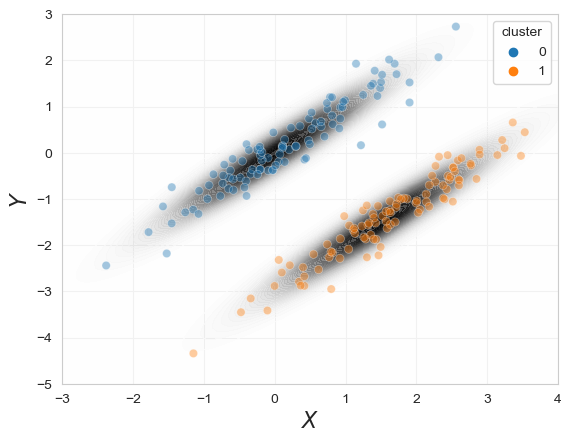

In [50]:
fig, ax = plt.subplots(1,1)
x = np.linspace(-3,4,100)
y = np.linspace(-5,3,100)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
ax.contourf(X, Y, gaussian_mixture_proba(pos, mu=mu, cov=cov, pi=pi), 50, cmap=cm.Greys, alpha=0.75)
sns.scatterplot(x='x', y='y', data=data_cigars, hue='cluster', alpha=0.4)
plt.xlim(-3, 4)
plt.ylim(-5, 3)
plt.ylabel(r'$Y$', fontsize=16)
plt.xlabel(r'$X$', fontsize=16);

As an esay example we had assumed that we already know the GMM parameters to show that the model can fit the data. The big problem is that we need to find these parameters $(\pi_j,\mu_j\Sigma_j)_{j=1,...,k}$ for the gaussian mixture which fits the data best. We will begin with the inference of parameters in GMM

For data $D={x_i:i=1,...,n}$ and parameters $\Theta$ model likelihood is given by

$$
\mathcal{L}(\Theta~|~D)= \prod_{i=1}^nP(X=x_i)=\prod_{i=1}^n\sum_{j=1}^k \pi_j\mathcal{N_p}(x;\mu_j,\Sigma_j)
$$

and log-likelihood is given as

$$
\log \mathcal{L}(\Theta~|~D)=\sum_{i=1}^n\log\sum_{j=1}^k \pi_j\mathcal{N_p}(x;\mu_j,\Sigma_j)
$$

The question now is how we can infer the parameters of a GMM that best explain the data? Our first idea is to compute the likelihood of the model parameters, given a data set $D$. To maximise this likelihood, we can try to simplify the likelihood expression using our standard trick, that is we take the logarithm and maximise the log-likelihood function instead.

Unfortunately, in the GMM this is not as simple as in our previous applications of maximum-likelihood estimation. We are left  with a logarithm of a sum of Gaussians, for which we cannot compute the derivative in a straight-forward way.

Expectation-Maximisation (EM)

Let us assume we knew the "correct" cluster $C(i)$ for each $x_i\in D$. We can write the likelihood of model parameters $\Theta$ based on joint distribution

$$
\mathcal{L}(\Theta~|~D)= \prod_{i=1}^nP(X=x_i,C=C(i)~|~\Theta).
$$

The log-likelihood of the model is

$$
\log \mathcal{L}(\Theta~|~D)= \sum_{i=1}^n\log P(X=x_i,C=C(i)~|~\Theta).
$$

For a guess of parameters $\Theta^{(t)} = (\pi_j,\mu_j\Sigma_j)_{j=1,...,k}$ the expected log-likelihood can be calculated as

$$
E[\log\mathcal{L}(\Theta~|~D)]= \sum_{i=1}^n \sum_{j=1}^k P(C=j~|~X=x_i,\Theta^{(t)})\log P(X=x_i,C=j~|~\Theta).
$$




To find the optimal parameters of the $k d$-dimensional multivariate Normal distributions that maximise the likelihood, we can apply a general and powerful iterative approach, the so-called expectation-maximisation (EM) algorithm. It is based on the idea that, rather than maximising the model likelihood based on the marginal probability $P(X)$, we can instead use an  estimate for the conditional probability $P(C~|~X)$ to compute the expected log-likelihood based on the joint distribution $P(X, C)$.

To better understand this, let us assume we knew the cluster $C(i)$ for each observation $x_i \in D$. For each we could then calculate the likelihood and log-likelihood function of our model based on the joint distribution $P(X, C)$. Unfortunately, we lack the information to which clusters the data points belong. However, we can capture this lack of information based on the conditional probability $P(C|X)$, which we can compute for any guess of parameters $\Theta^{(t)}$.

For $j=1,...,k$ we use guessed parameters $\Theta^{(t)}$ to calculate

$$
P(C=j~|~X=x_i,\Theta^{(t)})= \frac{\mathcal{N_d}(x;\mu_j,\Sigma_j)\pi_j}{\sum_{j=1}^k\mathcal{N_d}(x;\mu_j,\Sigma_j)}:=\gamma_{ij}.
$$ 

Update $\Theta^{(t)}\rightarrow \Theta^{(t+1)}$ such that $\gamma_{ij}$ and thus $E[\log\mathcal{L}(\Theta~|~D)]$ is maximal.
With $N_j:=\sum_{i=1}^n\gamma_{ij}$ expactation-maximising parameters are

$$
\pi_j = \frac{N_j}{n}, \quad \mu_j = \frac{1}{N_j}\sum_{i=1}^n\gamma_{ij}x_i, \quad \Sigma_j=\frac{1}{N_j}\sum_{i=1}^n\gamma_{ij}(x_i -\mu_j)(x_i-\mu_j)^T.
$$

The expactation-maximisation agorithm iteratively updates  $\Theta^{(t)}\rightarrow \Theta^{(t+1)}$ to find maximum-likehood parameters

The trick is now to compute $P(C~|~X)$ based on our current guess of $\Theta^{(t)}$ and then update the parameters such that $P(C~|~X)$ and the expected log-likelihood is maximised. Those maximum parameters can actually be determined by taking the
derivative of the conditional probability (the constraint $\sum_{j=1}\pi_j=1$ requires quadratic programming to find $\pi_j$).

We can now use the updated parameters to get a better estimate for the conditional probability, so we can simply repeat the procedure. In each step, we first compute the expectation for the model likelihood and then find the parameters that maximise this expectation, which is why the algorithm is called expectation-maximisation.

This yields an iterative algorithm, which starts from an initial guess of the model parameters and then, step-by-step, updates the model parameters to iteratively increase the model likelihood until we reach a maximum.

Text(0, 0.5, '$Y$')

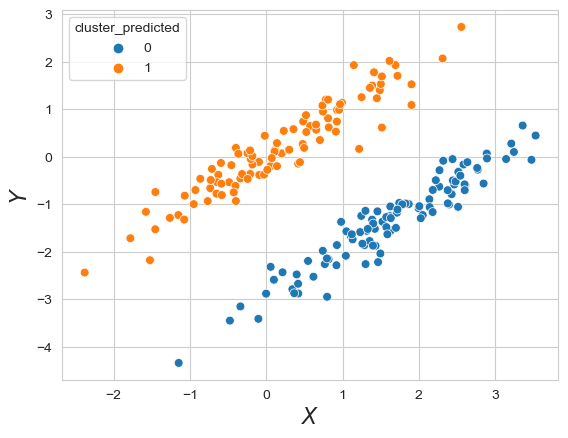

In [64]:
model = GaussianMixture(n_components=2, covariance_type='full')
model.fit(data_cigars[['x', 'y']])
data_cigars['cluster_predicted'] = model.predict(data_cigars[['x', 'y']])
plt.clf()
sns.scatterplot(x='x', y='y', s=40, hue='cluster_predicted', data=data_cigars)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16)